In [1]:
import ee
import collections
collections.Callable = collections.abc.Callable
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhRty3TcMUuxoNoUOXbih1w1_Wj8FbThud3FrgC11ih0frQlOU1f24

Successfully saved authorization token.


#### next steps: add in other indices, specifically moisture

## Imports & Visualization Parameters

In [2]:
import ee
import geemap

geometry = ee.Geometry.Polygon(
        [[[29.554129272985683, 3.1591674847348235],
          [29.554129272985683, 3.092319151883147],
          [29.625197083044277, 3.092319151883147],
          [29.625197083044277, 3.1591674847348235]]])
mines = ee.FeatureCollection("users/EmilyNason/cod_mines_curated_all_opendata_p_ipis")
gsw = ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')

area1 = ee.Geometry.Polygon(
        [[[25.783982219615126, -10.760592214819402],
          [25.783982219615126, -10.804773403670321],
          [25.882344188609267, -10.804773403670321],
          [25.882344188609267, -10.760592214819402]]], None, False)
area2 = ee.Geometry.Polygon(
        [[[25.883463192760367, -10.653415341387422],
          [25.883463192760367, -10.684961077984651],
          [25.918653775035757, -10.684961077984651],
          [25.918653775035757, -10.653415341387422]]], None, False)
area3 = ee.Geometry.Polygon(
        [[[26.117306035200816, -10.551319560770521],
          [26.117306035200816, -10.632650522900946],
          [26.248455327193003, -10.632650522900946],
          [26.248455327193003, -10.551319560770521]]], None, False)
area4 = ee.Geometry.Polygon(
        [[[25.961694541782418, -10.617121740523016],
          [25.961694541782418, -10.656262872369753],
          [26.00804311355976, -10.656262872369753],
          [26.00804311355976, -10.617121740523016]]], None, False)
noMine = ee.Geometry.Polygon(
        [[[26.05587044825878, -10.73615043816951],
          [26.05587044825878, -10.787712996362622],
          [26.14122124360419, -10.787712996362622],
          [26.14122124360419, -10.73615043816951]]], None, False)

rgbVis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

ndviVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']
}

ndmiVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'blue']
}

nirGVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'purple']
}

## True Color Composites

In [3]:
def create_median_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_median_composites(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
        
    return Map

In [4]:
images = create_median_composites(geometry, 2019, 2021)
Map = add_median_composites(images, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## NDVI

In [5]:
def create_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        ndvi = image.normalizedDifference(['B8', 'B4'])
        Map.addLayer(ndvi, ndviVis, 'NDVI ' + str(year))
        
    return Map

In [6]:
Map = create_ndvi_layers(images, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## NDMI

In [7]:
def create_ndmi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        ndmi = image.normalizedDifference(['B8', 'B11'])
        Map.addLayer(ndmi, ndmiVis, 'NDMI ' + str(year))
        
    return Map

In [8]:
Map = create_ndmi_layers(images, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## NIR/G

In [9]:
def create_nir_g_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        nirG = image.normalizedDifference(['B8', 'B3'])
        Map.addLayer(nirG, nirGVis, 'NIR/G ' + str(year))
        
    return Map

In [10]:
Map = create_nir_g_layers(images, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## VH Band

In [11]:
def create_vh_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select('VH')

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vh_composites(images, imagesVH, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesVH:
        Map.addLayer(image, {'min':-25, 'max':0}, str(year) + ' VH Composite')
        
    return Map

In [12]:
imagesS1vh = create_vh_composites(geometry, 2019, 2021)
Map = add_vh_composites(images, imagesS1vh, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### VH Calculations

In [17]:
cpThreshold = 8
permanentWater = gsw.select('seasonality').gte(7).clip(geometry)

In [18]:
def create_vh_calcs(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        Map.addLayer(composite, rgbVis, str(year) + ' Median Composite')
        
        ndvi = composite.normalizedDifference(['B8', 'B4'])
        nirG = composite.normalizedDifference(['B8', 'B3'])
        
        waterStorage = image.lt(-22).rename('water').And(nirG.lt(0.1)).selfMask()
        connectW = waterStorage.connectedPixelCount(25)
        waterStorage = waterStorage.updateMask(connectW.gt(cpThreshold))
        Map.addLayer(waterStorage, {'min':0, 'max':1, 'palette': ['blue']}, 'Water ' + str(year))
        
        mining = image.gte(-22).And(image.lt(-18)).And(ndvi.lt(.1)).rename('mine').selfMask()
        mining = mining.where(permanentWater,0).selfMask()
        connectM = mining.connectedPixelCount(25)
        mining = mining.updateMask(connectM.gt(cpThreshold))
        Map.addLayer(mining, {'min':0, 'max':1, 'palette': ['red']}, 'Mining Estimate ' + str(year))
        
    return Map

In [19]:
Map = create_vh_calcs(imagesS1vh, geometry)
legend_dict = {
    'Water': ('0000FF'), # blue
    'Mine Estimate': ('FF0000'), # red
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## VV Band

In [13]:
def create_vv_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select('VV')

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vv_composites(images, imagesVV, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesVV:
        Map.addLayer(image, {'min':-25, 'max':0}, str(year) + ' VV Composite')
        
    return Map

In [14]:
imagesS1vv = create_vv_composites(geometry, 2019, 2021)
Map = add_vv_composites(images, imagesS1vv, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### VV Calculations

In [18]:
def create_vv_calcs(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        Map.addLayer(composite, rgbVis, str(year) + ' Median Composite')
        
        ndvi = composite.normalizedDifference(['B8', 'B4'])
        nirG = composite.normalizedDifference(['B8', 'B3'])
        
        waterStorage = image.lt(-15).rename('water').And(nirG.lt(0.1)).selfMask()
        connectW = waterStorage.connectedPixelCount(25)
        waterStorage = waterStorage.updateMask(connectW.gt(cpThreshold))
        Map.addLayer(waterStorage, {'min':0, 'max':1, 'palette': ['blue']}, 'Water ' + str(year))
        
        mining = image.gte(-15).And(image.lt(-9)).And(ndvi.lt(.1)).rename('mine').selfMask()
        mining = mining.where(permanentWater,0).selfMask()
        connectM = mining.connectedPixelCount(25)
        mining = mining.updateMask(connectM.gt(cpThreshold))
        Map.addLayer(mining, {'min':0, 'max':1, 'palette': ['red']}, 'Mining Estimate ' + str(year))
        
    return Map

In [19]:
Map = create_vv_calcs(imagesS1vv, geometry)
legend_dict = {
    'Water': ('0000FF'), # blue
    'Mine Estimate': ('FF0000'), # red
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')

Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## VV/VH Ratio

In [15]:
def create_vv_vh_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select(['VV', 'VH'])

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vv_vh_composites(images, imagesRatio, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesRatio:
        Map.addLayer(image.select('VV').divide(image.select('VH')), {}, str(year) + ' VV/VH')
        
    return Map

In [16]:
imagesS1ratio = create_vv_vh_composites(geometry, 2019, 2021)
Map = add_vv_vh_composites(images, imagesS1ratio, geometry)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

### VV/VH Calculations

In [22]:
def create_vv_vh_calcs(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 11)
    
    for image, year in images:
        
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        Map.addLayer(composite, rgbVis, str(year) + ' Median Composite')
        
        ndvi = composite.normalizedDifference(['B8', 'B4'])
        nirG = composite.normalizedDifference(['B8', 'B3'])
        
        waterStorage = image.select('VV').divide(image.select('VH')).gt(0.6).And(nirG.lt(0.1)).rename('water').selfMask()
        connectW = waterStorage.connectedPixelCount(25)
        waterStorage = waterStorage.updateMask(connectW.gt(cpThreshold))
        Map.addLayer(waterStorage, {'min':0, 'max':1, 'palette': ['blue']}, 'Water ' + str(year))
        
        #currently not doing much -> basically going off of NDVI
        mining = image.select('VV').divide(image.select('VH')).lt(0.6).And(ndvi.lt(.1)).rename('mine').selfMask()
        mining = mining.where(permanentWater,0).selfMask()
        connectM = mining.connectedPixelCount(25)
        mining = mining.updateMask(connectM.gt(cpThreshold))
        Map.addLayer(mining, {'min':0, 'max':1, 'palette': ['red']}, 'Mining Estimate ' + str(year))
        
    return Map

In [23]:
Map = create_vv_vh_calcs(imagesS1ratio, geometry)

legend_dict = {
    'Water': ('0000FF'), # blue
    'Mine Estimate': ('FF0000'), # red
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')

Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

## Plotting SAR changes

In [24]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 100
    })
    
    properties = {
        'Year': image.get('system:index'),
        'VH': stats.get('VH'),
        'VV': stats.get('VV'),
        #'VV/VH': stats.get('VV/VH')
        #'NDVI': stats.get('ndvi'),
        #'NIR/G': stats.get('nirG')
    }
    
    return ee.Feature(None, properties)

In [25]:
def add_all_bands(image):
    vh = image.select('VH').rename('VH')
    vv = image.select('VV').rename('VV')
    # vv_vh = image.select('VV').divide(image.select('VH')).rename('VV/VH')
    #ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    #nirG = image.normalizedDifference(['B8', 'SR_B3']).rename('nirG')
    
    return image.addBands([vh, vv])

In [26]:
images1 = ee.ImageCollection(create_vv_vh_composites(area4, 2016, 2021))
with_bands1 = images1.map(add_all_bands)
data1 = ee.FeatureCollection(with_bands1.map(extract_data))
df1 = geemap.ee_to_pandas(data1)
images1 = create_vv_vh_composites(area4, 2016, 2021)

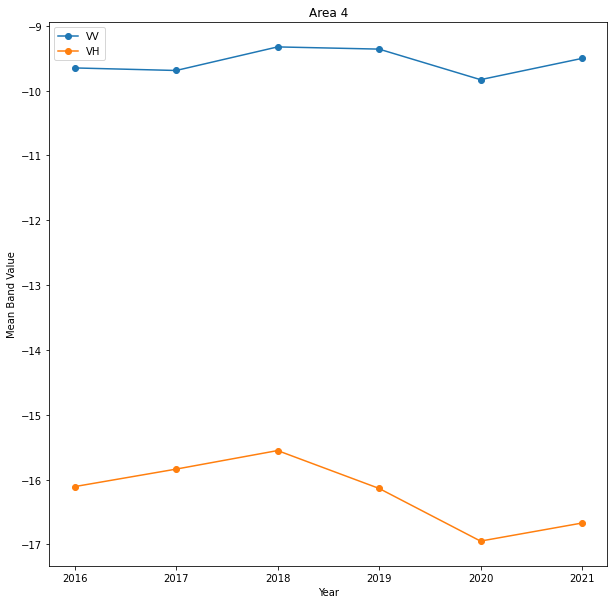

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

xticks = [t[1] for t in images1]
ax.set_xticks([0, 1, 2, 3, 4, 5], xticks)

df1.plot(ax=ax,
       title = 'Area 4',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

plt.show()